# 2. Pruning

This notebook demonstrates how to prune a model using the `torh.torch.nn.utils.prune` and `torch-pruning` library. Pruning is a technique to reduce the size of a neural network by removing weights that are deemed unnecessary, which can lead to faster inference times and reduced memory usage.

There is 2 types of pruning:
- **Unstructured pruning**: Removes individual weights using an importance metric (e.g., low-magnitude weights are pruned). This can lead to sparse models, which reduce drastically the number of parameters but must rely on specialized hardware and/or libraries to take advantage of the sparsity during inference.
- **Structured pruning**: Removes entire channels or layers, using a metric measuring an entire channel or layer importance (e.g., low-magnitude channels are pruned). This leads to a more regular model that can be used on standard hardware without requiring specialized libraries.

Metrics used for pruning are typically based on the magnitude of weights, gradients, or other statistics that indicate the importance of a weight or a channel.

The process is defined as such:
* A Torch model is loaded.
* A pruning strategy is defined, which specifies how to prune the model (e.g., unstructured or structured pruning, and the importance metric to use).
* The model is pruned using the defined strategy.
* The model is exported PyTorch format for further optimization or deployment.

2 pruning methods will be used in this notebook, both for 2 models (image and audio classification):
* L1-magntiude unstructured pruning using `torch.torch.nn.utils.prune`.
* L1-magnitude structured pruning using `torch-pruning`.

# Setup

In [1]:
from typing import Any

import torch

from matplotlib import pyplot as plt

from nnopt.model.utils import count_parameters
from nnopt.model.eval import eval_model
from nnopt.model.prune import prune_finetune
from nnopt.model.const import DEVICE, DTYPE

from nnopt.recipes.mobilenetv2_cifar10 import get_mobilenetv2_cifar10_model, get_cifar10_datasets, save_mobilenetv2_cifar10_model

2025-06-11 14:16:05,809 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Using device: cuda, dtype: torch.bfloat16


In [2]:
# MobilenetV2 CIFAR-10 model
mobilenetv2_cifar10_baseline, mobilenetv2_cifar10_baseline_metadata = get_mobilenetv2_cifar10_model(version="mobilenetv2_cifar10/fp32/baseline")

# CIFAR-10 datasets
cifar10_train_dataset, cifar10_val_dataset, cifar10_test_dataset = get_cifar10_datasets()

2025-06-11 14:16:06,626 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loading MobileNetV2 model for CIFAR-10 (architecture and weights) from version: mobilenetv2_cifar10/fp32/baseline at /home/pbeuran/repos/nnopt/models
2025-06-11 14:16:07,128 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Successfully loaded model from /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/baseline/model.pt
2025-06-11 14:16:07,129 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loaded metadata: {'metrics_values': {'val_metrics': {'accuracy': 0.8988, 'avg_loss': 0.2952394811630249, 'samples_per_second': 8822.506935259542, 'avg_time_per_batch': 0.007173827088484393, 'avg_time_per_sample': 0.00011334646799805342, 'params_stats': {'int_weight_params': 0, 'float_weight_params': 2202560, 'float_bias_params': 10, 'bn_param_params': 34112, 'other_float_params': 0, 'total_params': 2236682, 'approx_memory_mb_for_params': 8.532264709472656}}, 'test_metrics': {'accuracy': 0.9004, 'avg_loss': 0.29234390649795533, 'sa

In [3]:
# Evaluate the adapted model on the validation and test set
mobilenetv2_cifar10_baseline_val_metrics = eval_model(
    model=mobilenetv2_cifar10_baseline,
    test_dataset=cifar10_val_dataset,
    device=DEVICE,
    use_amp=False,
    dtype=torch.float32,
)
mobilenetv2_cifar10_baseline_test_metrics = eval_model(
    model=mobilenetv2_cifar10_baseline,
    test_dataset=cifar10_test_dataset,
    device=DEVICE,
    use_amp=False,
    dtype=torch.float32,
)

mobilenetv2_cifar10_val_accuracy_baseline = mobilenetv2_cifar10_baseline_val_metrics["accuracy"]
mobilenetv2_cifar10_test_accuracy_baseline = mobilenetv2_cifar10_baseline_test_metrics["accuracy"]
print(f"Validation accuracy of MobileNetV2 on CIFAR-10 (baseline): {mobilenetv2_cifar10_val_accuracy_baseline:.2f}")
print(f"Test accuracy of MobileNetV2 on CIFAR-10 (baseline): {mobilenetv2_cifar10_test_accuracy_baseline:.2f}")

2025-06-11 14:16:15,770 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.float32, batch size: 32
2025-06-11 14:16:15,774 - nnopt.model.eval - INFO - Starting warmup for 5 batches...
[Warmup]: 100%|██████████| 5/5 [00:01<00:00,  4.71it/s]
2025-06-11 14:16:16,938 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 157/157 [00:03<00:00, 49.47it/s, acc=0.8976, cpu=25.0%, gpu_mem=15.9/24.0GB (66.3%), gpu_util=35.0%, loss=0.3326, ram=10.3/30.9GB (44.0%), samples/s=463.6] 
2025-06-11 14:16:20,118 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.float32, batch size: 32
2025-06-11 14:16:20,121 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Evaluation Complete: Avg Loss: 0.2991, Accuracy: 0.8976
Throughput: 4071.13 samples/sec | Avg Batch Time: 7.82 ms | Avg Sample Time: 0.25 ms
System Stats: CPU Usage: 29.90% | RAM Usage: 10.0/30.9GB (43.2%) | GPU 0 Util: 35.00% | GPU 0 Mem: 15.9/24.0GB (66.3%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 17.88it/s]
2025-06-11 14:16:20,521 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 313/313 [00:06<00:00, 47.04it/s, acc=0.8981, cpu=39.8%, gpu_mem=15.9/24.0GB (66.2%), gpu_util=38.0%, loss=0.0930, ram=10.3/30.9GB (44.0%), samples/s=660.4] 


Evaluation Complete: Avg Loss: 0.2943, Accuracy: 0.8981
Throughput: 4160.45 samples/sec | Avg Batch Time: 7.68 ms | Avg Sample Time: 0.24 ms
System Stats: CPU Usage: 38.50% | RAM Usage: 10.0/30.9GB (43.3%) | GPU 0 Util: 38.00% | GPU 0 Mem: 15.9/24.0GB (66.2%)
Validation accuracy of MobileNetV2 on CIFAR-10 (baseline): 0.90
Test accuracy of MobileNetV2 on CIFAR-10 (baseline): 0.90


# L1 unstructured pruning

In [4]:
# Prune using L1 unstructured pruning, finetune, and evaluate for 0.5, 0.7, and 0.9 sparsity levels
unstruct_pruned_amount_model_version_map: dict[float, str] = {}
unstruct_pruned_amount_metrics_map: dict[float, Any] = {}
for sparsity in [0.5, 0.7, 0.9]:
    print("***" * 20)
    # Prune and finetune the model
    mobilenetv2_cifar10_pruned = prune_finetune(
    model=get_mobilenetv2_cifar10_model(version="mobilenetv2_cifar10/fp32/baseline")[0],
    train_dataset=cifar10_train_dataset,
    val_dataset=cifar10_val_dataset,
    pruning_method="l1_unstructured_pruning",
    pruning_amount=sparsity,
    batch_size=64,  # Adjust batch size as needed
    num_epochs=3,
    device=DEVICE,
    use_amp=True,
    dtype=DTYPE
)
    version_dir = f"mobilenetv2_cifar10/fp32/l1_unstruct_prune_{sparsity}"
    # Save the model and its metadata
    unstruct_pruned_amount_model_version_map[sparsity] = version_dir
    unstruct_pruned_amount_metrics_map[sparsity] = {
        "val_metrics": eval_model(
            model=mobilenetv2_cifar10_pruned,
            test_dataset=cifar10_val_dataset,
            batch_size=64,  # Adjust batch size as needed
            device=DEVICE,
            use_amp=False,
            dtype=torch.float32
        ),
        "test_metrics": eval_model(
            model=mobilenetv2_cifar10_pruned,
            test_dataset=cifar10_test_dataset,
            batch_size=64,  # Adjust batch size as needed
            device=DEVICE,
            use_amp=False,
            dtype=torch.float32
        ),
    }
    print(("***" * 20) + "\n")
    save_mobilenetv2_cifar10_model(
        model=mobilenetv2_cifar10_pruned,
        version=version_dir,
        unstruct_sparse_config={
            "pruning_amount": sparsity
        },
        metrics_values=unstruct_pruned_amount_metrics_map[sparsity]
    )

2025-06-11 14:16:32,520 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loading MobileNetV2 model for CIFAR-10 (architecture and weights) from version: mobilenetv2_cifar10/fp32/baseline at /home/pbeuran/repos/nnopt/models
2025-06-11 14:16:32,611 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Successfully loaded model from /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/baseline/model.pt
2025-06-11 14:16:32,612 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loaded metadata: {'metrics_values': {'val_metrics': {'accuracy': 0.8988, 'avg_loss': 0.2952394811630249, 'samples_per_second': 8822.506935259542, 'avg_time_per_batch': 0.007173827088484393, 'avg_time_per_sample': 0.00011334646799805342, 'params_stats': {'int_weight_params': 0, 'float_weight_params': 2202560, 'float_bias_params': 10, 'bn_param_params': 34112, 'other_float_params': 0, 'total_params': 2236682, 'approx_memory_mb_for_params': 8.532264709472656}}, 'test_metrics': {'accuracy': 0.9004, 'avg_loss': 0.29234390649795533, 'sa

************************************************************


2025-06-11 14:16:32,863 - nnopt.model.prune - INFO - Applied L1 unstructured pruning to 53 layers.
2025-06-11 14:16:32,864 - nnopt.model.prune - INFO - Evaluating the pruned model on the validation dataset...
2025-06-11 14:16:32,864 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.bfloat16, batch size: 64
2025-06-11 14:16:32,868 - nnopt.model.eval - INFO - Starting warmup for 5 batches...
[Warmup]: 100%|██████████| 5/5 [00:01<00:00,  2.96it/s]
2025-06-11 14:16:34,688 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:02<00:00, 26.57it/s, acc=0.0922, cpu=38.4%, gpu_mem=16.1/24.0GB (67.1%), gpu_util=29.0%, loss=2.4922, ram=10.6/30.9GB (46.9%), samples/s=244.7] 
2025-06-11 14:16:37,668 - nnopt.model.prune - INFO - Validation accuracy for pruned method l1_unstructured_pruning with pruning amount 0.50: 0.0922
2025-06-11 14:16:37,668 - nnopt.model.prune - INFO - Starting finetuning of the pruned model...


Evaluation Complete: Avg Loss: 2.3669, Accuracy: 0.0922
Throughput: 4893.22 samples/sec | Avg Batch Time: 12.93 ms | Avg Sample Time: 0.20 ms
System Stats: CPU Usage: 43.00% | RAM Usage: 10.4/30.9GB (46.1%) | GPU 0 Util: 30.00% | GPU 0 Mem: 16.1/24.0GB (67.1%)


Epoch 1/3 [Validation]: 100%|██████████| 79/79 [00:02<00:00, 37.06it/s, acc=0.8564, cpu=2.9%, gpu_mem=18.5/24.0GB (77.1%), gpu_util=33.0%, loss=0.7224, ram=10.6/30.9GB (46.7%), samples/s=1031.5] 


Epoch 1/3, Train Loss: 0.8885, Train Acc: 0.6900, Train Throughput: 1530.05 samples/s | Val Loss: 0.4326, Val Acc: 0.8564, Val Throughput: 6808.38 samples/s | CPU Usage: 11.90% | RAM Usage: 10.3/30.9GB (45.8%) | GPU 0 Util: 33.00% | GPU 0 Mem: 18.5/24.0GB (77.1%)


Epoch 2/3 [Validation]: 100%|██████████| 79/79 [00:02<00:00, 38.58it/s, acc=0.8872, cpu=3.3%, gpu_mem=18.5/24.0GB (77.1%), gpu_util=36.0%, loss=0.4368, ram=10.5/30.9GB (46.6%), samples/s=1138.3] 


Epoch 2/3, Train Loss: 0.7606, Train Acc: 0.7353, Train Throughput: 1935.77 samples/s | Val Loss: 0.3342, Val Acc: 0.8872, Val Throughput: 7256.42 samples/s | CPU Usage: 13.50% | RAM Usage: 10.3/30.9GB (45.9%) | GPU 0 Util: 36.00% | GPU 0 Mem: 18.5/24.0GB (77.1%)


Epoch 3/3 [Validation]: 100%|██████████| 79/79 [00:02<00:00, 36.72it/s, acc=0.8912, cpu=2.7%, gpu_mem=18.5/24.0GB (77.2%), gpu_util=36.0%, loss=0.4965, ram=10.4/30.9GB (46.4%), samples/s=949.7]  
2025-06-11 14:18:46,662 - nnopt.model.prune - INFO - Evaluating the pruned and finetuned model on the validation dataset...
2025-06-11 14:18:46,663 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.bfloat16, batch size: 64
2025-06-11 14:18:46,666 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Epoch 3/3, Train Loss: 0.7014, Train Acc: 0.7565, Train Throughput: 1892.72 samples/s | Val Loss: 0.3185, Val Acc: 0.8912, Val Throughput: 6919.69 samples/s | CPU Usage: 12.60% | RAM Usage: 10.2/30.9GB (45.7%) | GPU 0 Util: 34.00% | GPU 0 Mem: 18.5/24.0GB (77.2%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 11.19it/s]
2025-06-11 14:18:47,236 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:02<00:00, 36.16it/s, acc=0.8912, cpu=8.8%, gpu_mem=18.5/24.0GB (77.2%), gpu_util=32.0%, loss=0.4965, ram=10.5/30.9GB (46.5%), samples/s=1033.0] 
2025-06-11 14:18:49,426 - nnopt.model.prune - INFO - Validation accuracy for pruned and finetuned model: 0.8912
2025-06-11 14:18:49,427 - nnopt.model.prune - INFO - Making pruning permanent by removing reparameterization...
2025-06-11 14:18:49,429 - nnopt.model.prune - INFO - Made pruning permanent for 53 layers.
2025-06-11 14:18:49,430 - nnopt.model.prune - INFO - Removed pruning reparameterization from the pruned finetuned model.
2025-06-11 14:18:49,430 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.float32, batch size: 64
2025-06-11 14:18:49,433 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Evaluation Complete: Avg Loss: 0.3185, Accuracy: 0.8912
Throughput: 6472.76 samples/sec | Avg Batch Time: 9.78 ms | Avg Sample Time: 0.15 ms
System Stats: CPU Usage: 12.60% | RAM Usage: 10.2/30.9GB (45.7%) | GPU 0 Util: 32.00% | GPU 0 Mem: 18.5/24.0GB (77.2%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 12.43it/s]
2025-06-11 14:18:49,949 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:02<00:00, 37.85it/s, acc=0.8880, cpu=0.0%, gpu_mem=19.1/24.0GB (79.8%), gpu_util=56.0%, loss=0.4948, ram=10.5/30.9GB (46.4%), samples/s=1820.2] 
2025-06-11 14:18:52,042 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.float32, batch size: 64
2025-06-11 14:18:52,045 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Evaluation Complete: Avg Loss: 0.3219, Accuracy: 0.8880
Throughput: 5882.97 samples/sec | Avg Batch Time: 10.76 ms | Avg Sample Time: 0.17 ms
System Stats: CPU Usage: 11.60% | RAM Usage: 10.2/30.9GB (45.7%) | GPU 0 Util: 56.00% | GPU 0 Mem: 19.1/24.0GB (79.8%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 14.76it/s]
2025-06-11 14:18:52,510 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 157/157 [00:03<00:00, 40.20it/s, acc=0.8890, cpu=0.0%, gpu_mem=19.1/24.0GB (79.5%), gpu_util=51.0%, loss=0.1490, ram=10.4/30.9GB (46.3%), samples/s=3440.7] 
2025-06-11 14:18:56,475 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Metadata saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/l1_unstruct_prune_0.5/metadata.json
2025-06-11 14:18:56,476 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Model saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/l1_unstruct_prune_0.5/model.pt
2025-06-11 14:18:56,477 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loading MobileNetV2 model for CIFAR-10 (architecture and weights) from version: mobilenetv2_cifar10/fp32/baseline at /home/pbeuran/repos/nnopt/models
2025-06-11 14:18:56,514 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Successfully loaded model from /home/pbeuran/

Evaluation Complete: Avg Loss: 0.3292, Accuracy: 0.8890
Throughput: 6347.81 samples/sec | Avg Batch Time: 10.03 ms | Avg Sample Time: 0.16 ms
System Stats: CPU Usage: 12.50% | RAM Usage: 10.2/30.9GB (45.7%) | GPU 0 Util: 51.00% | GPU 0 Mem: 19.1/24.0GB (79.5%)
************************************************************

************************************************************


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 13.17it/s]
2025-06-11 14:18:57,030 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:02<00:00, 38.24it/s, acc=0.0686, cpu=5.7%, gpu_mem=19.1/24.0GB (79.5%), gpu_util=39.0%, loss=2.3516, ram=10.4/30.9GB (46.3%), samples/s=992.5]  
2025-06-11 14:18:59,101 - nnopt.model.prune - INFO - Validation accuracy for pruned method l1_unstructured_pruning with pruning amount 0.70: 0.0686
2025-06-11 14:18:59,101 - nnopt.model.prune - INFO - Starting finetuning of the pruned model...


Evaluation Complete: Avg Loss: 2.3111, Accuracy: 0.0686
Throughput: 7099.92 samples/sec | Avg Batch Time: 8.91 ms | Avg Sample Time: 0.14 ms
System Stats: CPU Usage: 14.00% | RAM Usage: 10.2/30.9GB (45.7%) | GPU 0 Util: 39.00% | GPU 0 Mem: 19.1/24.0GB (79.5%)


Epoch 1/3 [Validation]: 100%|██████████| 79/79 [00:02<00:00, 36.71it/s, acc=0.8040, cpu=8.3%, gpu_mem=19.0/24.0GB (79.4%), gpu_util=31.0%, loss=1.5535, ram=10.4/30.9GB (46.4%), samples/s=1016.3] 


Epoch 1/3, Train Loss: 1.1580, Train Acc: 0.5920, Train Throughput: 1809.38 samples/s | Val Loss: 0.5694, Val Acc: 0.8040, Val Throughput: 6764.58 samples/s | CPU Usage: 12.70% | RAM Usage: 10.2/30.9GB (45.7%) | GPU 0 Util: 31.00% | GPU 0 Mem: 19.0/24.0GB (79.4%)


Epoch 2/3 [Validation]: 100%|██████████| 79/79 [00:02<00:00, 37.01it/s, acc=0.8324, cpu=3.0%, gpu_mem=19.0/24.0GB (79.4%), gpu_util=39.0%, loss=1.4074, ram=10.5/30.9GB (46.6%), samples/s=1025.0] 


Epoch 2/3, Train Loss: 0.9178, Train Acc: 0.6765, Train Throughput: 1856.11 samples/s | Val Loss: 0.4837, Val Acc: 0.8324, Val Throughput: 6662.50 samples/s | CPU Usage: 11.50% | RAM Usage: 10.2/30.9GB (45.7%) | GPU 0 Util: 39.00% | GPU 0 Mem: 19.0/24.0GB (79.4%)


Epoch 3/3 [Validation]: 100%|██████████| 79/79 [00:02<00:00, 37.26it/s, acc=0.8516, cpu=2.9%, gpu_mem=19.0/24.0GB (79.3%), gpu_util=35.0%, loss=1.3424, ram=10.5/30.9GB (46.6%), samples/s=995.2]  
2025-06-11 14:21:00,089 - nnopt.model.prune - INFO - Evaluating the pruned and finetuned model on the validation dataset...
2025-06-11 14:21:00,090 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.bfloat16, batch size: 64
2025-06-11 14:21:00,093 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Epoch 3/3, Train Loss: 0.8256, Train Acc: 0.7110, Train Throughput: 1858.21 samples/s | Val Loss: 0.4350, Val Acc: 0.8516, Val Throughput: 6685.14 samples/s | CPU Usage: 11.30% | RAM Usage: 10.2/30.9GB (45.7%) | GPU 0 Util: 35.00% | GPU 0 Mem: 19.0/24.0GB (79.3%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 14.12it/s]
2025-06-11 14:21:00,569 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:02<00:00, 37.16it/s, acc=0.8516, cpu=5.4%, gpu_mem=19.0/24.0GB (79.4%), gpu_util=38.0%, loss=1.3424, ram=10.5/30.9GB (46.6%), samples/s=1008.9] 
2025-06-11 14:21:02,701 - nnopt.model.prune - INFO - Validation accuracy for pruned and finetuned model: 0.8516
2025-06-11 14:21:02,701 - nnopt.model.prune - INFO - Making pruning permanent by removing reparameterization...
2025-06-11 14:21:02,704 - nnopt.model.prune - INFO - Made pruning permanent for 53 layers.
2025-06-11 14:21:02,705 - nnopt.model.prune - INFO - Removed pruning reparameterization from the pruned finetuned model.
2025-06-11 14:21:02,707 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.float32, batch size: 64
2025-06-11 14:21:02,710 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Evaluation Complete: Avg Loss: 0.4350, Accuracy: 0.8516
Throughput: 6643.08 samples/sec | Avg Batch Time: 9.53 ms | Avg Sample Time: 0.15 ms
System Stats: CPU Usage: 11.30% | RAM Usage: 10.2/30.9GB (45.7%) | GPU 0 Util: 38.00% | GPU 0 Mem: 19.0/24.0GB (79.4%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 12.53it/s]
2025-06-11 14:21:03,223 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:02<00:00, 37.64it/s, acc=0.8494, cpu=4.0%, gpu_mem=19.0/24.0GB (79.4%), gpu_util=53.0%, loss=1.3066, ram=10.5/30.9GB (46.6%), samples/s=1756.3] 
2025-06-11 14:21:05,328 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.float32, batch size: 64
2025-06-11 14:21:05,330 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Evaluation Complete: Avg Loss: 0.4383, Accuracy: 0.8494
Throughput: 5917.66 samples/sec | Avg Batch Time: 10.70 ms | Avg Sample Time: 0.17 ms
System Stats: CPU Usage: 11.50% | RAM Usage: 10.2/30.9GB (45.7%) | GPU 0 Util: 53.00% | GPU 0 Mem: 19.0/24.0GB (79.4%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 14.55it/s]
2025-06-11 14:21:05,785 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 157/157 [00:03<00:00, 40.22it/s, acc=0.8437, cpu=4.5%, gpu_mem=19.0/24.0GB (79.3%), gpu_util=53.0%, loss=0.4012, ram=10.5/30.9GB (46.6%), samples/s=3555.1] 
2025-06-11 14:21:09,741 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Metadata saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/l1_unstruct_prune_0.7/metadata.json
2025-06-11 14:21:09,742 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Model saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/l1_unstruct_prune_0.7/model.pt
2025-06-11 14:21:09,743 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loading MobileNetV2 model for CIFAR-10 (architecture and weights) from version: mobilenetv2_cifar10/fp32/baseline at /home/pbeuran/repos/nnopt/models
2025-06-11 14:21:09,781 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Successfully loaded model from /home/pbeuran/

Evaluation Complete: Avg Loss: 0.4466, Accuracy: 0.8437
Throughput: 6212.58 samples/sec | Avg Batch Time: 10.25 ms | Avg Sample Time: 0.16 ms
System Stats: CPU Usage: 11.90% | RAM Usage: 10.2/30.9GB (45.7%) | GPU 0 Util: 53.00% | GPU 0 Mem: 19.0/24.0GB (79.3%)
************************************************************

************************************************************


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 11.79it/s]
2025-06-11 14:21:10,342 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:02<00:00, 37.97it/s, acc=0.1022, cpu=2.9%, gpu_mem=19.0/24.0GB (79.4%), gpu_util=37.0%, loss=2.2500, ram=10.4/30.9GB (46.4%), samples/s=1016.6] 
2025-06-11 14:21:12,428 - nnopt.model.prune - INFO - Validation accuracy for pruned method l1_unstructured_pruning with pruning amount 0.90: 0.1022
2025-06-11 14:21:12,429 - nnopt.model.prune - INFO - Starting finetuning of the pruned model...


Evaluation Complete: Avg Loss: 2.3365, Accuracy: 0.1022
Throughput: 7190.16 samples/sec | Avg Batch Time: 8.80 ms | Avg Sample Time: 0.14 ms
System Stats: CPU Usage: 10.90% | RAM Usage: 10.2/30.9GB (45.7%) | GPU 0 Util: 37.00% | GPU 0 Mem: 19.0/24.0GB (79.4%)


Epoch 1/3 [Validation]: 100%|██████████| 79/79 [00:02<00:00, 38.12it/s, acc=0.1086, cpu=5.9%, gpu_mem=19.0/24.0GB (79.3%), gpu_util=37.0%, loss=2.6481, ram=10.5/30.9GB (46.4%), samples/s=1029.6] 


Epoch 1/3, Train Loss: 1.9448, Train Acc: 0.2771, Train Throughput: 1917.30 samples/s | Val Loss: 4.6410, Val Acc: 0.1086, Val Throughput: 7005.05 samples/s | CPU Usage: 12.10% | RAM Usage: 10.3/30.9GB (45.8%) | GPU 0 Util: 37.00% | GPU 0 Mem: 19.0/24.0GB (79.3%)


Epoch 2/3 [Validation]: 100%|██████████| 79/79 [00:02<00:00, 36.80it/s, acc=0.2040, cpu=3.0%, gpu_mem=19.0/24.0GB (79.3%), gpu_util=44.0%, loss=7.3555, ram=10.5/30.9GB (46.4%), samples/s=1016.6] 


Epoch 2/3, Train Loss: 1.6884, Train Acc: 0.3853, Train Throughput: 1832.78 samples/s | Val Loss: 3.9550, Val Acc: 0.2040, Val Throughput: 6555.62 samples/s | CPU Usage: 14.20% | RAM Usage: 10.3/30.9GB (45.8%) | GPU 0 Util: 44.00% | GPU 0 Mem: 19.0/24.0GB (79.3%)


Epoch 3/3 [Validation]: 100%|██████████| 79/79 [00:02<00:00, 37.00it/s, acc=0.0940, cpu=3.1%, gpu_mem=19.0/24.0GB (79.3%), gpu_util=44.0%, loss=5.5159, ram=10.5/30.9GB (46.4%), samples/s=1005.5]  
2025-06-11 14:23:12,577 - nnopt.model.prune - INFO - Evaluating the pruned and finetuned model on the validation dataset...
2025-06-11 14:23:12,578 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.bfloat16, batch size: 64
2025-06-11 14:23:12,581 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Epoch 3/3, Train Loss: 1.5632, Train Acc: 0.4355, Train Throughput: 1767.93 samples/s | Val Loss: 8.8926, Val Acc: 0.0940, Val Throughput: 6813.35 samples/s | CPU Usage: 11.60% | RAM Usage: 10.2/30.9GB (45.7%) | GPU 0 Util: 44.00% | GPU 0 Mem: 19.0/24.0GB (79.3%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 11.99it/s]
2025-06-11 14:23:13,115 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:02<00:00, 37.16it/s, acc=0.0940, cpu=2.5%, gpu_mem=19.0/24.0GB (79.3%), gpu_util=42.0%, loss=5.5159, ram=10.4/30.9GB (46.4%), samples/s=883.9]   
2025-06-11 14:23:15,246 - nnopt.model.prune - INFO - Validation accuracy for pruned and finetuned model: 0.0940
2025-06-11 14:23:15,247 - nnopt.model.prune - INFO - Making pruning permanent by removing reparameterization...
2025-06-11 14:23:15,250 - nnopt.model.prune - INFO - Made pruning permanent for 53 layers.
2025-06-11 14:23:15,250 - nnopt.model.prune - INFO - Removed pruning reparameterization from the pruned finetuned model.
2025-06-11 14:23:15,252 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.float32, batch size: 64
2025-06-11 14:23:15,255 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Evaluation Complete: Avg Loss: 8.8926, Accuracy: 0.0940
Throughput: 6553.08 samples/sec | Avg Batch Time: 9.66 ms | Avg Sample Time: 0.15 ms
System Stats: CPU Usage: 11.90% | RAM Usage: 10.2/30.9GB (45.7%) | GPU 0 Util: 42.00% | GPU 0 Mem: 19.0/24.0GB (79.3%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 12.24it/s]
2025-06-11 14:23:15,779 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:02<00:00, 36.90it/s, acc=0.1004, cpu=8.3%, gpu_mem=19.0/24.0GB (79.4%), gpu_util=59.0%, loss=3.9185, ram=10.5/30.9GB (46.6%), samples/s=1702.7] 
2025-06-11 14:23:17,926 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.float32, batch size: 64
2025-06-11 14:23:17,929 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Evaluation Complete: Avg Loss: 6.9935, Accuracy: 0.1004
Throughput: 5706.89 samples/sec | Avg Batch Time: 11.09 ms | Avg Sample Time: 0.18 ms
System Stats: CPU Usage: 11.80% | RAM Usage: 10.2/30.9GB (45.7%) | GPU 0 Util: 59.00% | GPU 0 Mem: 19.0/24.0GB (79.4%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 14.68it/s]
2025-06-11 14:23:18,385 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 157/157 [00:03<00:00, 39.46it/s, acc=0.1068, cpu=4.0%, gpu_mem=19.0/24.0GB (79.3%), gpu_util=57.0%, loss=6.5367, ram=10.5/30.9GB (46.6%), samples/s=3293.2] 
2025-06-11 14:23:22,415 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Metadata saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/l1_unstruct_prune_0.9/metadata.json
2025-06-11 14:23:22,416 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Model saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/l1_unstruct_prune_0.9/model.pt


Evaluation Complete: Avg Loss: 6.8733, Accuracy: 0.1068
Throughput: 5681.52 samples/sec | Avg Batch Time: 11.21 ms | Avg Sample Time: 0.18 ms
System Stats: CPU Usage: 12.00% | RAM Usage: 10.2/30.9GB (45.7%) | GPU 0 Util: 54.00% | GPU 0 Mem: 19.0/24.0GB (79.3%)
************************************************************



In [5]:
# Print the sparsity and accuracy results
for sparsity, metrics in unstruct_pruned_amount_metrics_map.items():
    print(f"Sparsity: {sparsity:.2f}, Validation Accuracy: {metrics['val_metrics']['accuracy']:.2f}, Test Accuracy: {metrics['test_metrics']['accuracy']:.2f}")

Sparsity: 0.50, Validation Accuracy: 0.89, Test Accuracy: 0.89
Sparsity: 0.70, Validation Accuracy: 0.85, Test Accuracy: 0.84
Sparsity: 0.90, Validation Accuracy: 0.10, Test Accuracy: 0.11


# L1 structured pruning

In [6]:
# Prune using L1 structured pruning, finetune, and evaluate for 0.5, 0.7, and 0.9 sparsity levels
struct_pruned_amount_model_version_map: dict[float, str] = {}
struct_pruned_amount_metrics_map: dict[float, dict[str, float]] = {}
for sparsity in [0.1, 0.3, 0.5]:
    print("***" * 20)
    # Prune and finetune the model
    _mobilnet_v2_cifar10_model, _ = get_mobilenetv2_cifar10_model(version="mobilenetv2_cifar10/fp32/baseline")
    mobilenetv2_cifar10_pruned = prune_finetune(
    model=_mobilnet_v2_cifar10_model.to(DEVICE),
    train_dataset=cifar10_train_dataset,
    val_dataset=cifar10_val_dataset,
    pruning_method="l1_structured_pruning",
    pruning_amount=sparsity,
    pruning_kwargs={
        "example_inputs": torch.randn(1, 3, 224, 224, device=DEVICE),  # Example input for structured pruning
    },
    batch_size=64,  # Adjust batch size as needed
    num_epochs=3,
    device=DEVICE,
    use_amp=True,
    dtype=DTYPE
)
    version_dir = f"mobilenetv2_cifar10/fp32/l1_struct_prune_{sparsity}"
    # Save the model and its metadata
    struct_pruned_amount_model_version_map[sparsity] = version_dir
    struct_pruned_amount_metrics_map[sparsity] = {
        "val_metrics": eval_model(
            model=mobilenetv2_cifar10_pruned,
            test_dataset=cifar10_val_dataset,
            batch_size=64,  # Adjust batch size as needed
            device=DEVICE,
            use_amp=False,
            dtype=torch.float32
        ),
        "test_metrics": eval_model(
            model=mobilenetv2_cifar10_pruned,
            test_dataset=cifar10_test_dataset,
            batch_size=64,  # Adjust batch size as needed
            device=DEVICE,
            use_amp=False,
            dtype=torch.float32
        ),
        "relative_sparsity": count_parameters(mobilenetv2_cifar10_pruned)["total_params"]/count_parameters(mobilenetv2_cifar10_baseline)["total_params"]
    }
    
    save_mobilenetv2_cifar10_model(
        model=mobilenetv2_cifar10_pruned,
        version=version_dir,
        metrics_values=struct_pruned_amount_metrics_map[sparsity]
    )

2025-06-11 14:23:22,436 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loading MobileNetV2 model for CIFAR-10 (architecture and weights) from version: mobilenetv2_cifar10/fp32/baseline at /home/pbeuran/repos/nnopt/models


************************************************************


2025-06-11 14:23:22,644 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Successfully loaded model from /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/baseline/model.pt
2025-06-11 14:23:22,645 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loaded metadata: {'metrics_values': {'val_metrics': {'accuracy': 0.8988, 'avg_loss': 0.2952394811630249, 'samples_per_second': 8822.506935259542, 'avg_time_per_batch': 0.007173827088484393, 'avg_time_per_sample': 0.00011334646799805342, 'params_stats': {'int_weight_params': 0, 'float_weight_params': 2202560, 'float_bias_params': 10, 'bn_param_params': 34112, 'other_float_params': 0, 'total_params': 2236682, 'approx_memory_mb_for_params': 8.532264709472656}}, 'test_metrics': {'accuracy': 0.9004, 'avg_loss': 0.29234390649795533, 'samples_per_second': 8450.564700334979, 'avg_time_per_batch': 0.007537279433337601, 'avg_time_per_sample': 0.00011833528710340034, 'params_stats': {'int_weight_params': 0, 'float_weight_params': 2202560, 'float_bias_param

Evaluation Complete: Avg Loss: 4.3909, Accuracy: 0.1050
Throughput: 7664.19 samples/sec | Avg Batch Time: 8.26 ms | Avg Sample Time: 0.13 ms
System Stats: CPU Usage: 13.10% | RAM Usage: 10.4/30.9GB (46.3%) | GPU 0 Util: 30.00% | GPU 0 Mem: 19.0/24.0GB (79.3%)


Epoch 1/3 [Validation]: 100%|██████████| 79/79 [00:02<00:00, 29.26it/s, acc=0.7810, cpu=3.1%, gpu_mem=19.1/24.0GB (79.6%), gpu_util=39.0%, loss=1.3065, ram=10.6/30.9GB (47.0%), samples/s=1090.5] 


Epoch 1/3, Train Loss: 1.1638, Train Acc: 0.5883, Train Throughput: 1982.50 samples/s | Val Loss: 0.6428, Val Acc: 0.7810, Val Throughput: 7749.48 samples/s | CPU Usage: 10.90% | RAM Usage: 10.4/30.9GB (46.3%) | GPU 0 Util: 39.00% | GPU 0 Mem: 19.1/24.0GB (79.6%)


Epoch 2/3 [Validation]: 100%|██████████| 79/79 [00:02<00:00, 37.48it/s, acc=0.8140, cpu=3.0%, gpu_mem=19.0/24.0GB (79.4%), gpu_util=37.0%, loss=0.8723, ram=10.6/30.9GB (47.0%), samples/s=1120.9] 


Epoch 2/3, Train Loss: 0.9413, Train Acc: 0.6718, Train Throughput: 1984.18 samples/s | Val Loss: 0.5292, Val Acc: 0.8140, Val Throughput: 7956.61 samples/s | CPU Usage: 12.20% | RAM Usage: 10.4/30.9GB (46.4%) | GPU 0 Util: 37.00% | GPU 0 Mem: 19.0/24.0GB (79.4%)


Epoch 3/3 [Validation]: 100%|██████████| 79/79 [00:02<00:00, 37.78it/s, acc=0.8482, cpu=6.5%, gpu_mem=19.0/24.0GB (79.4%), gpu_util=34.0%, loss=1.0031, ram=10.7/30.9GB (47.0%), samples/s=1098.5]  
2025-06-11 14:25:26,923 - nnopt.model.prune - INFO - Evaluating the pruned and finetuned model on the validation dataset...
2025-06-11 14:25:26,923 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.bfloat16, batch size: 64
2025-06-11 14:25:26,926 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Epoch 3/3, Train Loss: 0.8443, Train Acc: 0.7060, Train Throughput: 1985.47 samples/s | Val Loss: 0.4433, Val Acc: 0.8482, Val Throughput: 8336.61 samples/s | CPU Usage: 12.10% | RAM Usage: 10.4/30.9GB (46.4%) | GPU 0 Util: 34.00% | GPU 0 Mem: 19.0/24.0GB (79.4%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 15.65it/s]
2025-06-11 14:25:27,370 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:02<00:00, 38.09it/s, acc=0.8482, cpu=0.0%, gpu_mem=19.1/24.0GB (79.4%), gpu_util=33.0%, loss=1.0031, ram=10.7/30.9GB (47.0%), samples/s=1170.7] 
2025-06-11 14:25:29,449 - nnopt.model.prune - INFO - Validation accuracy for pruned and finetuned model: 0.8482
2025-06-11 14:25:29,450 - nnopt.model.prune - INFO - Making pruning permanent by removing reparameterization...
2025-06-11 14:25:29,450 - nnopt.model.prune - WARNING - No pruning reparameterization was removed. Was the model pruned?
2025-06-11 14:25:29,451 - nnopt.model.prune - INFO - Removed pruning reparameterization from the pruned finetuned model.
2025-06-11 14:25:29,453 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.float32, batch size: 64
2025-06-11 14:25:29,456 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Evaluation Complete: Avg Loss: 0.4433, Accuracy: 0.8482
Throughput: 8517.82 samples/sec | Avg Batch Time: 7.43 ms | Avg Sample Time: 0.12 ms
System Stats: CPU Usage: 11.30% | RAM Usage: 10.4/30.9GB (46.4%) | GPU 0 Util: 33.00% | GPU 0 Mem: 19.1/24.0GB (79.4%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 12.25it/s]
2025-06-11 14:25:29,991 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:02<00:00, 38.11it/s, acc=0.8470, cpu=3.2%, gpu_mem=19.1/24.0GB (79.5%), gpu_util=44.0%, loss=0.9601, ram=10.6/30.9GB (47.0%), samples/s=469.0]  
2025-06-11 14:25:32,069 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.float32, batch size: 64
2025-06-11 14:25:32,072 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Evaluation Complete: Avg Loss: 0.4482, Accuracy: 0.8470
Throughput: 7146.13 samples/sec | Avg Batch Time: 8.86 ms | Avg Sample Time: 0.14 ms
System Stats: CPU Usage: 12.70% | RAM Usage: 10.4/30.9GB (46.4%) | GPU 0 Util: 44.00% | GPU 0 Mem: 19.1/24.0GB (79.5%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 11.86it/s]
2025-06-11 14:25:32,617 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 157/157 [00:03<00:00, 40.71it/s, acc=0.8436, cpu=1.6%, gpu_mem=19.1/24.0GB (79.5%), gpu_util=45.0%, loss=0.2384, ram=10.7/30.9GB (47.0%), samples/s=953.8]  
2025-06-11 14:25:36,523 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Metadata saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/l1_struct_prune_0.1/metadata.json
2025-06-11 14:25:36,524 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Model saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/l1_struct_prune_0.1/model.pt
2025-06-11 14:25:36,524 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loading MobileNetV2 model for CIFAR-10 (architecture and weights) from version: mobilenetv2_cifar10/fp32/baseline at /home/pbeuran/repos/nnopt/models
2025-06-11 14:25:36,565 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Successfully loaded model from /home/pbeuran/repo

Evaluation Complete: Avg Loss: 0.4680, Accuracy: 0.8436
Throughput: 7573.64 samples/sec | Avg Batch Time: 8.41 ms | Avg Sample Time: 0.13 ms
System Stats: CPU Usage: 10.90% | RAM Usage: 10.4/30.9GB (46.4%) | GPU 0 Util: 37.00% | GPU 0 Mem: 19.1/24.0GB (79.5%)
************************************************************


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 14.83it/s]
2025-06-11 14:25:37,137 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:02<00:00, 37.79it/s, acc=0.0934, cpu=2.7%, gpu_mem=19.1/24.0GB (79.5%), gpu_util=31.0%, loss=5.5015, ram=10.7/30.9GB (47.3%), samples/s=383.0]   
2025-06-11 14:25:39,233 - nnopt.model.prune - INFO - Validation accuracy for pruned method l1_structured_pruning with pruning amount 0.30: 0.0934
2025-06-11 14:25:39,233 - nnopt.model.prune - INFO - Starting finetuning of the pruned model...


Evaluation Complete: Avg Loss: 8.1687, Accuracy: 0.0934
Throughput: 8376.87 samples/sec | Avg Batch Time: 7.56 ms | Avg Sample Time: 0.12 ms
System Stats: CPU Usage: 11.60% | RAM Usage: 10.4/30.9GB (46.4%) | GPU 0 Util: 26.00% | GPU 0 Mem: 19.1/24.0GB (79.5%)


Epoch 1/3 [Validation]: 100%|██████████| 79/79 [00:02<00:00, 38.69it/s, acc=0.6010, cpu=3.4%, gpu_mem=19.1/24.0GB (79.5%), gpu_util=27.0%, loss=1.1395, ram=10.7/30.9GB (47.0%), samples/s=1275.1] 


Epoch 1/3, Train Loss: 1.6320, Train Acc: 0.4095, Train Throughput: 2519.84 samples/s | Val Loss: 1.1260, Val Acc: 0.6010, Val Throughput: 8766.15 samples/s | CPU Usage: 10.40% | RAM Usage: 10.5/30.9GB (46.4%) | GPU 0 Util: 27.00% | GPU 0 Mem: 19.1/24.0GB (79.5%)


Epoch 2/3 [Validation]: 100%|██████████| 79/79 [00:02<00:00, 38.48it/s, acc=0.6954, cpu=3.4%, gpu_mem=19.1/24.0GB (79.5%), gpu_util=27.0%, loss=0.6760, ram=10.7/30.9GB (47.0%), samples/s=1363.0] 


Epoch 2/3, Train Loss: 1.2991, Train Acc: 0.5395, Train Throughput: 2554.67 samples/s | Val Loss: 0.9018, Val Acc: 0.6954, Val Throughput: 8841.13 samples/s | CPU Usage: 10.50% | RAM Usage: 10.5/30.9GB (46.4%) | GPU 0 Util: 27.00% | GPU 0 Mem: 19.1/24.0GB (79.5%)


Epoch 3/3 [Validation]: 100%|██████████| 79/79 [00:02<00:00, 37.90it/s, acc=0.7406, cpu=5.9%, gpu_mem=19.1/24.0GB (79.5%), gpu_util=30.0%, loss=0.5876, ram=10.7/30.9GB (47.3%), samples/s=1215.4] 
2025-06-11 14:27:37,981 - nnopt.model.prune - INFO - Evaluating the pruned and finetuned model on the validation dataset...
2025-06-11 14:27:37,981 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.bfloat16, batch size: 64
2025-06-11 14:27:37,985 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Epoch 3/3, Train Loss: 1.1540, Train Acc: 0.5916, Train Throughput: 2491.31 samples/s | Val Loss: 0.7472, Val Acc: 0.7406, Val Throughput: 8459.52 samples/s | CPU Usage: 12.60% | RAM Usage: 10.5/30.9GB (46.4%) | GPU 0 Util: 30.00% | GPU 0 Mem: 19.1/24.0GB (79.5%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 14.72it/s]
2025-06-11 14:27:38,449 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:02<00:00, 38.67it/s, acc=0.7406, cpu=6.1%, gpu_mem=19.1/24.0GB (79.5%), gpu_util=36.0%, loss=0.5876, ram=10.7/30.9GB (47.3%), samples/s=1227.1] 
2025-06-11 14:27:40,498 - nnopt.model.prune - INFO - Validation accuracy for pruned and finetuned model: 0.7406
2025-06-11 14:27:40,498 - nnopt.model.prune - INFO - Making pruning permanent by removing reparameterization...
2025-06-11 14:27:40,499 - nnopt.model.prune - WARNING - No pruning reparameterization was removed. Was the model pruned?
2025-06-11 14:27:40,499 - nnopt.model.prune - INFO - Removed pruning reparameterization from the pruned finetuned model.
2025-06-11 14:27:40,502 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.float32, batch size: 64
2025-06-11 14:27:40,504 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Evaluation Complete: Avg Loss: 0.7472, Accuracy: 0.7406
Throughput: 8509.18 samples/sec | Avg Batch Time: 7.44 ms | Avg Sample Time: 0.12 ms
System Stats: CPU Usage: 12.10% | RAM Usage: 10.5/30.9GB (46.4%) | GPU 0 Util: 36.00% | GPU 0 Mem: 19.1/24.0GB (79.5%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 12.40it/s]
2025-06-11 14:27:41,030 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:02<00:00, 38.23it/s, acc=0.7400, cpu=1.7%, gpu_mem=19.1/24.0GB (79.5%), gpu_util=33.0%, loss=0.5820, ram=10.7/30.9GB (47.3%), samples/s=490.1]   
2025-06-11 14:27:43,101 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.float32, batch size: 64
2025-06-11 14:27:43,104 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Evaluation Complete: Avg Loss: 0.7506, Accuracy: 0.7400
Throughput: 9320.44 samples/sec | Avg Batch Time: 6.79 ms | Avg Sample Time: 0.11 ms
System Stats: CPU Usage: 10.40% | RAM Usage: 10.5/30.9GB (46.4%) | GPU 0 Util: 33.00% | GPU 0 Mem: 19.1/24.0GB (79.5%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 12.01it/s]
2025-06-11 14:27:43,643 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 157/157 [00:03<00:00, 40.57it/s, acc=0.7429, cpu=7.9%, gpu_mem=19.1/24.0GB (79.5%), gpu_util=31.0%, loss=0.8788, ram=10.7/30.9GB (47.3%), samples/s=940.8]   
2025-06-11 14:27:47,555 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Metadata saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/l1_struct_prune_0.3/metadata.json
2025-06-11 14:27:47,556 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Model saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/l1_struct_prune_0.3/model.pt
2025-06-11 14:27:47,557 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Loading MobileNetV2 model for CIFAR-10 (architecture and weights) from version: mobilenetv2_cifar10/fp32/baseline at /home/pbeuran/repos/nnopt/models
2025-06-11 14:27:47,595 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Successfully loaded model from /home/pbeuran/rep

Evaluation Complete: Avg Loss: 0.7538, Accuracy: 0.7429
Throughput: 9841.98 samples/sec | Avg Batch Time: 6.47 ms | Avg Sample Time: 0.10 ms
System Stats: CPU Usage: 12.10% | RAM Usage: 10.5/30.9GB (46.4%) | GPU 0 Util: 33.00% | GPU 0 Mem: 19.1/24.0GB (79.5%)
************************************************************


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 14.25it/s]
2025-06-11 14:27:48,175 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:02<00:00, 38.49it/s, acc=0.0970, cpu=3.9%, gpu_mem=19.1/24.0GB (79.5%), gpu_util=32.0%, loss=3.3643, ram=10.7/30.9GB (47.3%), samples/s=370.7]  
2025-06-11 14:27:50,232 - nnopt.model.prune - INFO - Validation accuracy for pruned method l1_structured_pruning with pruning amount 0.50: 0.0970
2025-06-11 14:27:50,232 - nnopt.model.prune - INFO - Starting finetuning of the pruned model...


Evaluation Complete: Avg Loss: 3.2465, Accuracy: 0.0970
Throughput: 8710.49 samples/sec | Avg Batch Time: 7.27 ms | Avg Sample Time: 0.11 ms
System Stats: CPU Usage: 10.80% | RAM Usage: 10.5/30.9GB (46.4%) | GPU 0 Util: 25.00% | GPU 0 Mem: 19.1/24.0GB (79.5%)


Epoch 1/3 [Validation]: 100%|██████████| 79/79 [00:02<00:00, 37.43it/s, acc=0.4490, cpu=0.0%, gpu_mem=19.1/24.0GB (79.7%), gpu_util=29.0%, loss=1.2964, ram=10.7/30.9GB (47.1%), samples/s=1335.8] 


Epoch 1/3, Train Loss: 1.8884, Train Acc: 0.3015, Train Throughput: 2645.49 samples/s | Val Loss: 1.5088, Val Acc: 0.4490, Val Throughput: 8456.71 samples/s | CPU Usage: 11.10% | RAM Usage: 10.5/30.9GB (46.4%) | GPU 0 Util: 29.00% | GPU 0 Mem: 19.1/24.0GB (79.7%)


Epoch 2/3 [Validation]: 100%|██████████| 79/79 [00:02<00:00, 38.05it/s, acc=0.5138, cpu=0.0%, gpu_mem=19.1/24.0GB (79.6%), gpu_util=25.0%, loss=1.5286, ram=10.7/30.9GB (47.1%), samples/s=1296.9]  


Epoch 2/3, Train Loss: 1.6409, Train Acc: 0.4034, Train Throughput: 2612.51 samples/s | Val Loss: 1.3198, Val Acc: 0.5138, Val Throughput: 8544.15 samples/s | CPU Usage: 11.70% | RAM Usage: 10.5/30.9GB (46.4%) | GPU 0 Util: 25.00% | GPU 0 Mem: 19.1/24.0GB (79.6%)


Epoch 3/3 [Validation]: 100%|██████████| 79/79 [00:02<00:00, 37.78it/s, acc=0.5742, cpu=0.0%, gpu_mem=19.1/24.0GB (79.6%), gpu_util=27.0%, loss=1.3335, ram=10.8/30.9GB (47.4%), samples/s=1108.3]  
2025-06-11 14:29:48,991 - nnopt.model.prune - INFO - Evaluating the pruned and finetuned model on the validation dataset...
2025-06-11 14:29:48,991 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.bfloat16, batch size: 64
2025-06-11 14:29:48,995 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Epoch 3/3, Train Loss: 1.5013, Train Acc: 0.4600, Train Throughput: 2584.85 samples/s | Val Loss: 1.1976, Val Acc: 0.5742, Val Throughput: 8490.57 samples/s | CPU Usage: 11.20% | RAM Usage: 10.6/30.9GB (46.8%) | GPU 0 Util: 27.00% | GPU 0 Mem: 19.1/24.0GB (79.6%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 12.05it/s]
2025-06-11 14:29:49,536 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:02<00:00, 38.44it/s, acc=0.5742, cpu=3.6%, gpu_mem=19.1/24.0GB (79.6%), gpu_util=22.0%, loss=1.3335, ram=10.9/30.9GB (47.7%), samples/s=1248.5]  
2025-06-11 14:29:51,596 - nnopt.model.prune - INFO - Validation accuracy for pruned and finetuned model: 0.5742
2025-06-11 14:29:51,597 - nnopt.model.prune - INFO - Making pruning permanent by removing reparameterization...
2025-06-11 14:29:51,597 - nnopt.model.prune - WARNING - No pruning reparameterization was removed. Was the model pruned?
2025-06-11 14:29:51,598 - nnopt.model.prune - INFO - Removed pruning reparameterization from the pruned finetuned model.
2025-06-11 14:29:51,601 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.float32, batch size: 64
2025-06-11 14:29:51,604 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Evaluation Complete: Avg Loss: 1.1976, Accuracy: 0.5742
Throughput: 8276.18 samples/sec | Avg Batch Time: 7.65 ms | Avg Sample Time: 0.12 ms
System Stats: CPU Usage: 13.20% | RAM Usage: 10.6/30.9GB (46.8%) | GPU 0 Util: 20.00% | GPU 0 Mem: 19.1/24.0GB (79.6%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 12.79it/s]
2025-06-11 14:29:52,119 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 79/79 [00:02<00:00, 37.51it/s, acc=0.5764, cpu=3.1%, gpu_mem=19.1/24.0GB (79.6%), gpu_util=32.0%, loss=1.3289, ram=10.8/30.9GB (47.4%), samples/s=470.6]   
2025-06-11 14:29:54,231 - nnopt.model.eval - INFO - Starting evaluation on device: cuda, dtype: torch.float32, batch size: 64
2025-06-11 14:29:54,234 - nnopt.model.eval - INFO - Starting warmup for 5 batches...


Evaluation Complete: Avg Loss: 1.1855, Accuracy: 0.5764
Throughput: 11975.15 samples/sec | Avg Batch Time: 5.29 ms | Avg Sample Time: 0.08 ms
System Stats: CPU Usage: 10.40% | RAM Usage: 10.5/30.9GB (46.7%) | GPU 0 Util: 32.00% | GPU 0 Mem: 19.1/24.0GB (79.6%)


[Warmup]: 100%|██████████| 5/5 [00:00<00:00, 12.46it/s]
2025-06-11 14:29:54,765 - nnopt.model.eval - INFO - Warmup complete.
[Evaluation]: 100%|██████████| 157/157 [00:03<00:00, 39.90it/s, acc=0.5775, cpu=1.6%, gpu_mem=19.1/24.0GB (79.6%), gpu_util=38.0%, loss=1.0336, ram=10.7/30.9GB (47.3%), samples/s=916.9]   
2025-06-11 14:29:58,741 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Metadata saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/l1_struct_prune_0.5/metadata.json
2025-06-11 14:29:58,742 - nnopt.recipes.mobilenetv2_cifar10 - INFO - Model saved to /home/pbeuran/repos/nnopt/models/mobilenetv2_cifar10/fp32/l1_struct_prune_0.5/model.pt


Evaluation Complete: Avg Loss: 1.1824, Accuracy: 0.5775
Throughput: 11145.46 samples/sec | Avg Batch Time: 5.71 ms | Avg Sample Time: 0.09 ms
System Stats: CPU Usage: 12.40% | RAM Usage: 10.5/30.9GB (46.7%) | GPU 0 Util: 38.00% | GPU 0 Mem: 19.1/24.0GB (79.6%)


# Analysis

## GPU

### L1 unstructured pruning

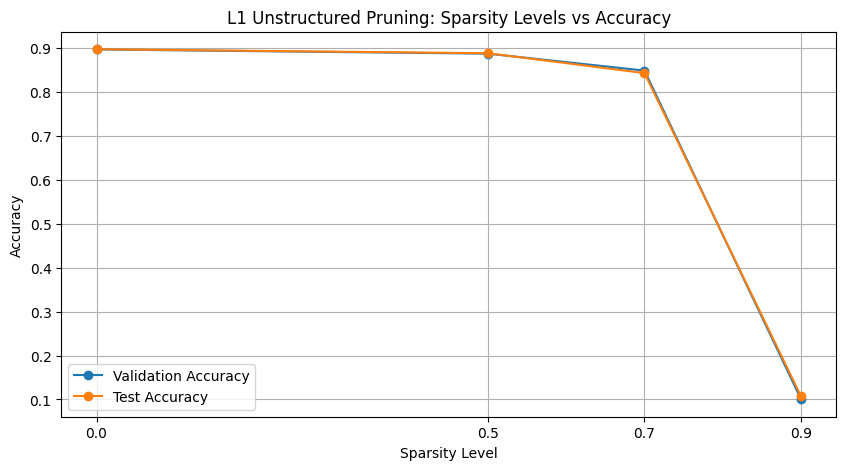

In [7]:
# Plot the sparsity levels vs accuracy for validation and test sets (baseline is considered as 0 sparsity)
sparsity_levels = [0.] + list(unstruct_pruned_amount_metrics_map.keys())
val_accuracies = [mobilenetv2_cifar10_val_accuracy_baseline] + [unstruct_pruned_amount_metrics_map[sparsity]["val_metrics"]["accuracy"] for sparsity in sparsity_levels[1:]]
test_accuracies = [mobilenetv2_cifar10_test_accuracy_baseline] + [unstruct_pruned_amount_metrics_map[sparsity]["test_metrics"]["accuracy"] for sparsity in sparsity_levels[1:]]
plt.figure(figsize=(10, 5))
plt.plot(sparsity_levels, val_accuracies, marker='o', label='Validation Accuracy')
plt.plot(sparsity_levels, test_accuracies, marker='o', label='Test Accuracy')
plt.title('L1 Unstructured Pruning: Sparsity Levels vs Accuracy')
plt.xlabel('Sparsity Level')
plt.ylabel('Accuracy')
plt.xticks(sparsity_levels)
plt.grid()
plt.legend()
plt.show()

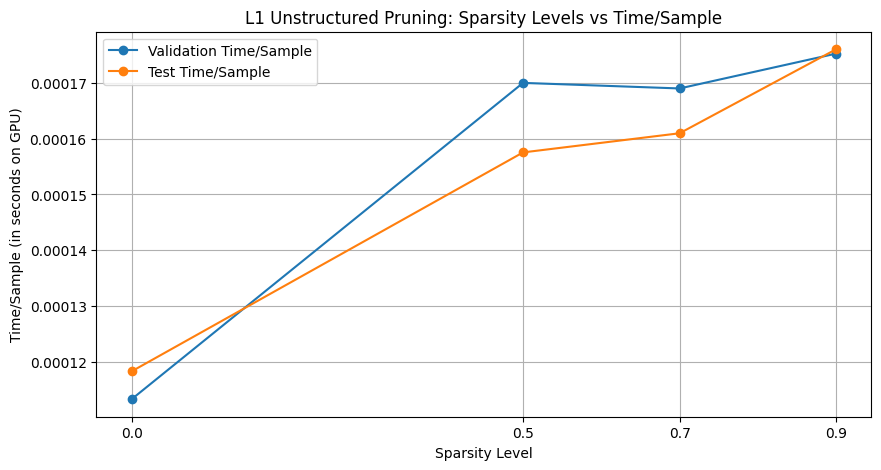

In [8]:
# Plot the average time per sample for validation and test sets (baseline is considered as 0 sparsity)
sparsity_levels = [0.] + list(unstruct_pruned_amount_metrics_map.keys())
val_time_per_sample = [mobilenetv2_cifar10_baseline_metadata["metrics_values"]["val_metrics"]["avg_time_per_sample"]] + [unstruct_pruned_amount_metrics_map[sparsity]["val_metrics"]["avg_time_per_sample"] for sparsity in sparsity_levels[1:]]
test_time_per_sample = [mobilenetv2_cifar10_baseline_metadata["metrics_values"]["test_metrics"]["avg_time_per_sample"]] + [unstruct_pruned_amount_metrics_map[sparsity]["test_metrics"]["avg_time_per_sample"] for sparsity in sparsity_levels[1:]]
plt.figure(figsize=(10, 5))
plt.plot(sparsity_levels, val_time_per_sample, marker='o', label='Validation Time/Sample')
plt.plot(sparsity_levels, test_time_per_sample, marker='o', label='Test Time/Sample')
plt.title('L1 Unstructured Pruning: Sparsity Levels vs Time/Sample')
plt.xlabel('Sparsity Level')
plt.ylabel('Time/Sample (in seconds on GPU)')
plt.xticks(sparsity_levels)
plt.grid()
plt.legend()
plt.show()

### L1 structured pruning

In [9]:
# Print the sparsity and accuracy results
for sparsity, metrics in struct_pruned_amount_metrics_map.items():
    print(f"Sparsity: {sparsity:.2f}, Relative Sparsity: {metrics['relative_sparsity']:.2f}, Validation Accuracy: {metrics['val_metrics']['accuracy']:.2f}, Test Accuracy: {metrics['test_metrics']['accuracy']:.2f}")

Sparsity: 0.10, Relative Sparsity: 0.66, Validation Accuracy: 0.85, Test Accuracy: 0.84
Sparsity: 0.30, Relative Sparsity: 0.27, Validation Accuracy: 0.74, Test Accuracy: 0.74
Sparsity: 0.50, Relative Sparsity: 0.10, Validation Accuracy: 0.58, Test Accuracy: 0.58


In [10]:
# Print the average time per sample for validation and test sets (baseline is considered as 0 sparsity)
for sparsity, metrics in struct_pruned_amount_metrics_map.items():
    print(f"Sparsity: {sparsity:.2f}, Validation Time/Sample: {metrics['val_metrics']['avg_time_per_sample']:.4f}, Test Time/Sample: {metrics['test_metrics']['avg_time_per_sample']:.8f}")

Sparsity: 0.10, Validation Time/Sample: 0.0001, Test Time/Sample: 0.00013204
Sparsity: 0.30, Validation Time/Sample: 0.0001, Test Time/Sample: 0.00010161
Sparsity: 0.50, Validation Time/Sample: 0.0001, Test Time/Sample: 0.00008972


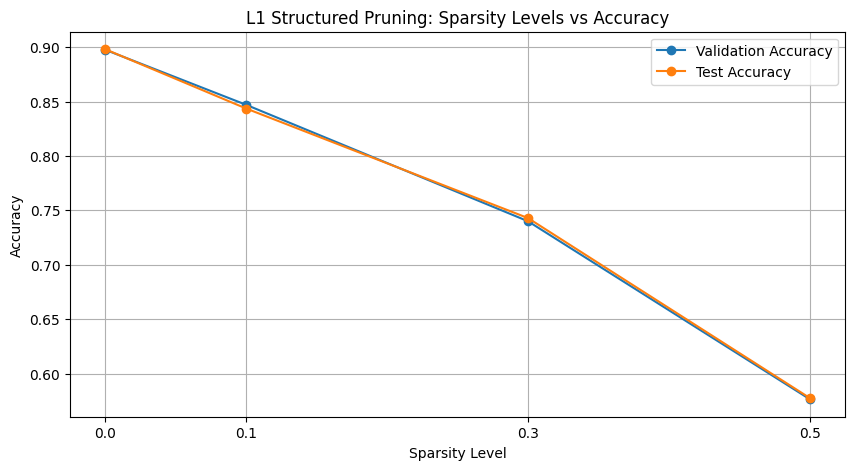

In [11]:
# Plot the sparsity levels vs accuracy for validation and test sets (baseline is considered as 0 sparsity)
sparsity_levels = [0.] + list(struct_pruned_amount_metrics_map.keys())
val_accuracies = [mobilenetv2_cifar10_val_accuracy_baseline] + [struct_pruned_amount_metrics_map[sparsity]["val_metrics"]["accuracy"] for sparsity in sparsity_levels[1:]]
test_accuracies = [mobilenetv2_cifar10_test_accuracy_baseline] + [struct_pruned_amount_metrics_map[sparsity]["test_metrics"]["accuracy"] for sparsity in sparsity_levels[1:]]
plt.figure(figsize=(10, 5))
plt.plot(sparsity_levels, val_accuracies, marker='o', label='Validation Accuracy')
plt.plot(sparsity_levels, test_accuracies, marker='o', label='Test Accuracy')
plt.title('L1 Structured Pruning: Sparsity Levels vs Accuracy')
plt.xlabel('Sparsity Level')
plt.ylabel('Accuracy')
plt.xticks(sparsity_levels)
plt.grid()
plt.legend()
plt.show()

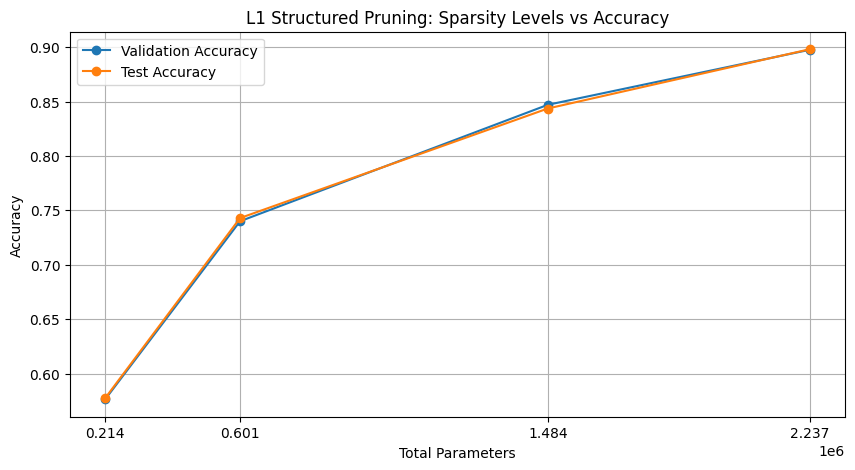

In [12]:
# Plot the total parameters vs accuracy for validation and test sets (baseline is considered as 0 sparsity)
sparsity_levels = [0.] + list(struct_pruned_amount_metrics_map.keys())
total_parameters = [count_parameters(mobilenetv2_cifar10_baseline)["total_params"]] + [struct_pruned_amount_metrics_map[sparsity]["test_metrics"]["params_stats"]["total_params"] for sparsity in sparsity_levels[1:]]
val_accuracies = [mobilenetv2_cifar10_val_accuracy_baseline] + [struct_pruned_amount_metrics_map[sparsity]["val_metrics"]["accuracy"] for sparsity in sparsity_levels[1:]]
test_accuracies = [mobilenetv2_cifar10_test_accuracy_baseline] + [struct_pruned_amount_metrics_map[sparsity]["test_metrics"]["accuracy"] for sparsity in sparsity_levels[1:]]
plt.figure(figsize=(10, 5))
plt.plot(total_parameters, val_accuracies, marker='o', label='Validation Accuracy')
plt.plot(total_parameters, test_accuracies, marker='o', label='Test Accuracy')
plt.title('L1 Structured Pruning: Sparsity Levels vs Accuracy')
plt.xlabel('Total Parameters')
plt.ylabel('Accuracy')
plt.xticks(total_parameters)
plt.grid()
plt.legend()
plt.show()

In [13]:
struct_pruned_amount_metrics_map[sparsity]["test_metrics"]

{'accuracy': 0.5775,
 'avg_loss': 1.1824188550949097,
 'samples_per_second': 11145.455460358882,
 'avg_time_per_batch': 0.0057148196179568796,
 'avg_time_per_sample': 8.972266800192302e-05,
 'params_stats': {'int_weight_params': 0,
  'float_weight_params': 205176,
  'float_bias_params': 10,
  'bn_param_params': 9024,
  'other_float_params': 0,
  'total_params': 214210,
  'approx_memory_mb_for_params': 0.8171463012695312}}

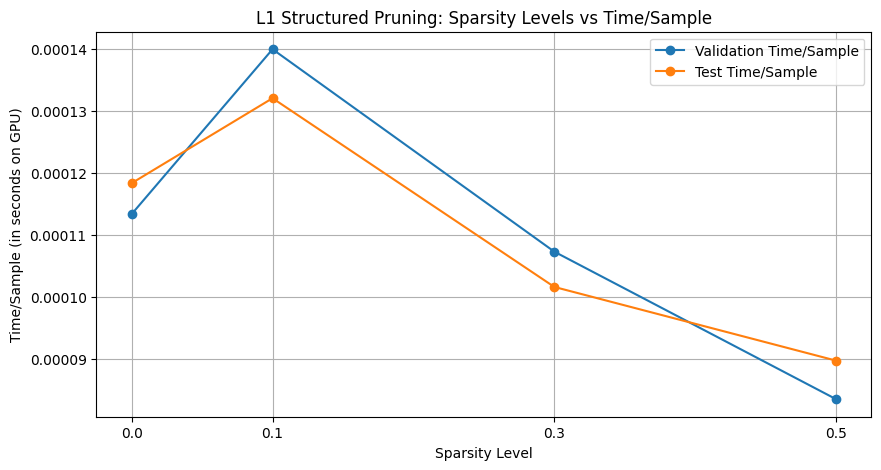

In [14]:
# Plot the average time per sample for validation and test sets (baseline is considered as 0 sparsity)
sparsity_levels = [0.] + list(struct_pruned_amount_metrics_map.keys())
val_time_per_sample = [mobilenetv2_cifar10_baseline_metadata["metrics_values"]["val_metrics"]["avg_time_per_sample"]] + [struct_pruned_amount_metrics_map[sparsity]["val_metrics"]["avg_time_per_sample"] for sparsity in sparsity_levels[1:]]
test_time_per_sample = [mobilenetv2_cifar10_baseline_metadata["metrics_values"]["test_metrics"]["avg_time_per_sample"]] + [struct_pruned_amount_metrics_map[sparsity]["test_metrics"]["avg_time_per_sample"] for sparsity in sparsity_levels[1:]]
plt.figure(figsize=(10, 5))
plt.plot(sparsity_levels, val_time_per_sample, marker='o', label='Validation Time/Sample')
plt.plot(sparsity_levels, test_time_per_sample, marker='o', label='Test Time/Sample')
plt.title('L1 Structured Pruning: Sparsity Levels vs Time/Sample')
plt.xlabel('Sparsity Level')
plt.ylabel('Time/Sample (in seconds on GPU)')
plt.xticks(sparsity_levels)
plt.grid()
plt.legend()
plt.show()

## Conclusions

* L1 unstructured pruning is effective at making the model sparse and keeping the accuracy high (up until 90% sparsity where there is a significant drop in accuracy). However, no accelaration is observed nor on GPU or CPU. This is due to  Pytorch's backend that does not support sparse tensors for inference, meaning that the pruned weights are still present in the model and do not lead to reduced computation time.
* L1 structured pruning succeeds also into reducing the model size and inference time (except for an outlier) while keeping the model dense, but at the higher cost of accuracy drop. This is due to the fact that entire channels are removed, which can lead to a more significant loss of information compared to unstructured pruning.
* As libraries and hardware support is often for dense models, structured pruning is often preferred for deployment, as it leads to a more regular model that can be used on standard hardware without requiring specialized libraries. However, unstructured pruning can be used provided that the hardware and libraries used for inference support sparse tensors.